In [1]:
import warnings                                      #기존의 필요한 것들을 다 import
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')            #이번 노드중 2번쨰것을 사용하여 간단하게 코딩함
test_data_path = join(data_dir, 'test.csv')              

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print('얍💢')

얍💢


In [3]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)#data의 구성을 노드에서 이미 봤으므로 data중에서 년월일만 사용하기 위해
train.head()                                                     #람다를 이용하였다.

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [4]:
y = train['price']                   #price는 타겟 값이므로 트레인 데이터에선 삭제
del train['price']                   #test 데이터에는 이미 없으므로 삭제 안해도 된다.

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [5]:
del train['id']                  #아이디는 필요없는 데이터 이므로 삭제 해 준다.

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [6]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [7]:
y   

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

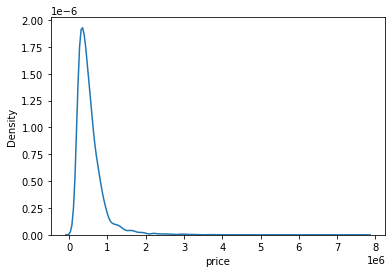

In [8]:
sns.kdeplot(y)
plt.show()             #y의 값이 앞쪽으로 치우쳐져 있는것을 알 수 있다. 데이터 처리가 필요

In [9]:
y = np.log1p(y)                     #y를 로그화 하여 x앞쪽 부분은 y의 편차가 크게 뒤의 x값은 y의 차이가 줄어 x앞쪽은 넓게 x뒤쪽은 좁게 만드는 효과가 있다.
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

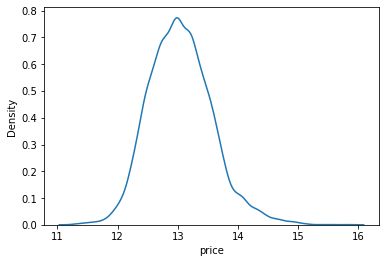

In [10]:
sns.kdeplot(y)          #정규 분포에 가깝게 된것을 볼 수 있다.
plt.show()

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [12]:
#모델 튜닝을 하기 위해선 여러 가지 반복되는 작업들은 함수로 먼저 만들어 놓고 많은 실험하는게 좋다 우선 함수화.
#훈련 검증을 위한 train_test_split RMSE 점수 계산을 위한 mean_squared_error 을 import

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

print('얍💢')

얍💢


In [14]:
#대회와 같은 평가 척도인 RMSE를 계산하기위해서 함수를 만든다. 그런데 y_test나 y_pred는 위에서 np.log1p()로 변환이 된 값이므로
#다시 원래 단위로 만들기 위해서 np.expm1()을 추가해 준다.

In [15]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

print('얍💢')

얍💢


In [16]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

print('얍💢')

얍💢


In [17]:
# XGBRegressor, LGBMRegressor, GradientBoostingRegressor, RandomForestRegressor 모델 파라미터 초기화나 데이터셋 구성에 사용되는 
#랜덤 시드값인 random_state 값을 특정 값으로 random_state를 고정값으로 주면 모델과 데이터셋이 동일한 경우 머신러닝 학습결과도 
#항상 동일하게 재현 none값을 주면 항상 랜덤하게 된다. 우리는 성능을 올려주는 하이퍼 파라미터를 찾으려 하는 것 이기 떄문에 값을 고정.

In [18]:
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

print('얍💢')

얍💢


In [19]:
gboost.__class__.__name__

'GradientBoostingRegressor'

In [20]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 128360.19649691365,
 'XGBRegressor': 110318.66956616656,
 'LGBMRegressor': 111920.36735892233,
 'RandomForestRegressor': 125487.07102453562}

In [21]:
def get_scores(models, train, y):                #대회 결과값인 RMSE를 계산하는 함수를 만든다.
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,128360.196497
RandomForestRegressor,125487.071025
LGBMRegressor,111920.367359
XGBRegressor,110318.669566


In [22]:
#위의 까지 과정이 하이퍼 파라미터들을 찾을때 RMSE 결과값을 계산값을 계산 할 수 있다. 따라서 여러 하이퍼 파라미터들을 변화 해 가면서
#성능 항상이 이뤄지는지 그떄의 하이퍼 파라미터가 뭔지 찾을 수 있을것이다.

In [23]:
from sklearn.model_selection import GridSearchCV

print('얍💢')

얍💢


In [24]:
#우선 그리드 탐색과 랜덤 탐색을 알아볼 필요가 있습니다. 두 가지 모두 하이퍼 파라미터를 조합해 보는 방법
#그리드 탐색은 사람이 먼저 탐색할 하이퍼 파라미터의 값들을 정해두고, 그 값들로 만들어질 수 있는 모든 조합을 탐색
#특정 값에 대한 하이퍼 파라미터 조합을 모두 탐색하고자 할 때 유리
#랜덤 탐색은 사람이 탐색할 하이퍼 파라미터의 공간 그 안에서 랜덤으로 조합을 선택해서 탐색
#따라서 평균값은 그리드 탐색 고점은 랜덤 탐색이 높다라고 생각하였다.

#다양한 파라미터를 입력하면 가능한 모든 조합을 탐색하는 사이킷런의 GridSearchCV를 활용

In [25]:
#GridSearchCV에 입력되는 인자
#param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)왜?
#scoring : 모델의 성능을 평가할 지표
#cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
#verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력
#n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수

In [26]:
param_grid = { 'n_estimators': [50, 100],'max_depth': [1, 10],}

In [27]:
model = LGBMRegressor(random_state=random_state)

print('얍💢')

얍💢


In [28]:
#그러면 model, param_grid와 함께 다른 여러 가지 인자를 넣어서 GridSearchCV를 수행할 수 있다?

In [29]:
#GridSearchCV를 이용해서 grid_model 모델을 초기화
#train과 y 데이터로 모델을 간단히 학습             
#이 2가지로 파라미터 조합에 대한 실험
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [30]:
#입력한 param_grid에 n_estimators 2 max_depth 2 넣었으므로 가능한 조합은 총 2 × 2 =4
#cross validation은 회당 5번을 진행하니 총 20 fits를 진행
#5번 진행 후 평균을 취하는 이유는 일반화 오차를 신뢰도 높게 추정하기 위해


In [31]:
grid_model.cv_results_
#파라미터 조합은 위 딕셔너리 중 params에, 각각에 대한 테스트 점수는 mean_test_score에 저장 우리가 필요한 데이터는 2가지
#따라서 따로 추출 필요

{'mean_fit_time': array([0.15456867, 0.18743978, 0.31507258, 0.50123534]),
 'std_fit_time': array([0.05958502, 0.00143803, 0.00958566, 0.09107443]),
 'mean_score_time': array([0.01377559, 0.01097555, 0.01697154, 0.03567414]),
 'std_score_time': array([0.00935255, 0.00070536, 0.00045236, 0.00996696]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02885847, -0.02665428]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.03041465, -0.02795896]),
 'split2_test_score': array([-0.07354904

In [32]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [33]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07339447, -0.05502043, -0.02917734, -0.02702714])

In [34]:
results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,1,50,-0.073394
1,1,100,-0.055020
2,10,50,-0.029177
3,10,100,-0.027027


In [35]:
#GridSearchCV로 grid_model 모델을 초기화할 때, scoring 인자MSE에 음수를 취한 값인 neg_mean_squared_error를 입력하기 때문에 스코어가
#음수로 나온다. GridSearchCV로 구하는 종류는 Classification, Clustering, Regression 로 구분할 수 있는데 이번에 우리가 구하는 것은
#Regression 이므로  neg_mean_squared_error를 사용한것이다. 음수로 된 점수를 변환 할 필요가 생긴다.

In [36]:
results['RMSE'] = np.sqrt(-1 * results['score'])#-1를 곱해줘 양수화.
results

,max_depth,n_estimators,score,RMSE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [37]:
# price의 분포가 한쪽으로 치우쳐져 있는 것을 보고 log 변환하는 과정이 있었는데 그리드 탐색중에는 np.exp1()으로 다시 원래 형태로 변환
# 하지 않았기 때문에 log 변환되어 있는 price 데이터에서 손실함수값을 계산한것. 그 때문에 제대로 된 값이 나오지 않았다.

In [38]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [39]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [40]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [41]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.13580793, 13.08051399, 14.11202067, ..., 13.01592878,
       12.69894979, 12.96297768])

In [42]:
prediction = np.expm1(prediction)
prediction

array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302])

In [43]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [44]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.067667e+05
1,15036,4.795061e+05
2,15037,1.345155e+06
3,15038,3.122579e+05
4,15039,3.338645e+05


In [45]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv


In [46]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
print('{} saved!'.format(submission_csv_path))

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv saved!


In [47]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')

In [48]:
#앞의 과정은 이번 노드 2번쨰를 한번 해본 것이다. 이번에 진짜로 요구하는것은 아래의 하이퍼 파라미터를 가지고 좀더 나은 결과를 구하는것이다.
#max_depth : 의사 결정 나무의 깊이, 정수 사용
#learning_rate : 한 스텝에 이동하는 양을 결정하는 파라미터, 보통 0.0001~0.1 사이의 실수 사용
#n_estimators : 사용하는 개별 모델의 개수, 보통 50~100 이상의 정수 사용
#num_leaves : 하나의 LightGBM 트리가 가질 수 있는 최대 잎의 수
#boosting_type : 부스팅 방식, gbdt, rf 등의 문자열 입력

In [49]:
#기존에 있는 데이터의 피처를 모델을 보다 잘 표현할 수 있는 형태로 처리하기 (피처 엔지니어링)
#LGBMRegressor, XGBRegressor, RandomForestRegressor 세 가지 이상의 다양한 모델에 대해 하이퍼 파라미터 튜닝하기
#다양한 하이퍼 파라미터에 대해 그리드 탐색을 시도해서 최적의 조합을 찾아보기
#Baseline 커널에서 활용했던 블렌딩 방법 활용

In [50]:
#기존에 있는 데이터의 피처를 모델을 보다 잘 표현할 수 있는 형태로 처리하기 (피처 엔지니어링)
#LGBMRegressor, XGBRegressor, RandomForestRegressor 세 가지 이상의 다양한 모델에 대해 하이퍼 파라미터 튜닝하기
#다양한 하이퍼 파라미터에 대해 그리드 탐색을 시도해서 최적의 조합을 찾아보기
#Baseline 커널에서 활용했던 블렌딩 방법 활용하기

In [51]:
#여러개를 캐글에서 참조하는 중 건축적인 마인드가 들어간 캐글을 보고 이것을 해석해 보는것도 공부가 될 것 같아서
#그냥 이것을 왜 넣었고 무슨 의미인지를 해석하는것에 초점을 둬봤다.

In [52]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

In [53]:
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore')        #각종 필요한 라이브러리 임폴트

In [54]:
def print_best_params(model, params):           
    grid_model = GridSearchCV(
        model, 
        param_grid = params,
        cv=5,
        scoring='neg_mean_squared_error')

    grid_model.fit(df_train_features, df_train_target)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print(
        '{0} 5 CV 시 최적 평균 RMSE 값 {1}, 최적 alpha:{2}'.format(model.__class__.__name__, np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

In [55]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

df_train = pd.read_csv(train_data_path)
df_test = pd.read_csv(test_data_path)

print('얍💢')

얍💢


In [56]:
for df in [df_train, df_test]:
	df['sale_yr'] = pd.to_numeric(df.date.str.slice(0, 4))          #새로운 파라미터를 만들기 위해서 구매한 연도
	df['sale_month'] = pd.to_numeric(df.date.str.slice(4, 6))       #구매한 달
	df['sale_day'] = pd.to_numeric(df.date.str.slice(6, 8))         #구매한 일
	df.drop(['id', 'date'], axis=1, inplace=True)

In [57]:
df_train = df_train.astype('float32')
df_test = df_test.astype('float32')

In [58]:
for df in [df_train, df_test]:
	#재건축 여부
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x < 0 else 1)    #건축연도와 개조(수리) 여부의 차를 판별하여 재건축 여부라는 파라미터를 만들었다.
	
    # 용적률 주거 공간 / 대지 면적을 하나의 파라미터로 설정
    df['far1'] = df['sqft_living'] / df['sqft_lot']      
    # Full Bath 수는 주거에 가장 중요한 요소중에 하나이다. 대부분 방 몇개 화장실 몇개가 흔히 판단되는 집의 요소 이므로 추가
    df['full_bath'] = (df['bathrooms'] / 1) 
    df['full_bath'] = df['full_bath'].astype('int')

    df['75bath'] = (df['bathrooms'] - df['full_bath']) / 0.75
    df['75bath'] = df['75bath'].astype('int')

    df['50bath'] = (df['bathrooms'] - df['full_bath'] - df['75bath']*0.75) / 0.5
    df['50bath'] = df['50bath'].astype('int')

    df['25bath'] = (df['bathrooms'] - df['full_bath'] - df['75bath']*0.75 - df['50bath']*0.5) / 0.25
    df['25bath'] = df['25bath'].astype('int')

    df['total_bath'] = df['full_bath'] + df['75bath'] + df['50bath'] + df['25bath']

    # 층당 화장실 개수      
    df['bath_per_floors'] = df['total_bath'] / df['floors']

    # 방당 화장실 개수
    df['bath_per_rooms'] = df['total_bath'] / df['bedrooms']

In [59]:
df_train['per_price'] = df_train['price'] / df_train['sqft_living']
zipcode_price = df_train.groupby(['zipcode'])['per_price'].agg({'mean'}).reset_index()
df_train = pd.merge(df_train,zipcode_price,how='left',on='zipcode')
df_test = pd.merge(df_test,zipcode_price,how='left',on='zipcode')

In [60]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
for df in [df_train, df_test]:
    df['zipcode_mean'] = df['mean'] * df['sqft_living']
    del df['mean']
    df['zipcode'] = encoder.fit_transform(df['zipcode'])
    df.drop([
        'sale_day', 'full_bath', '75bath', 
        '50bath', '25bath', 'sqft_living15', 'sqft_lot15'], axis=1, inplace=True)

df_train.drop(['per_price'], axis=1, inplace=True)

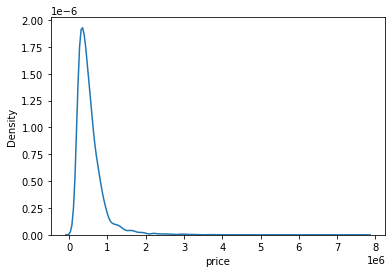

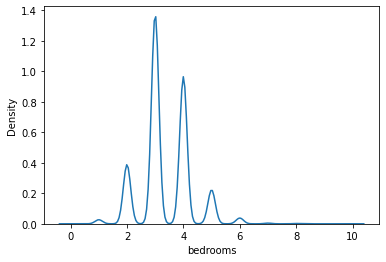

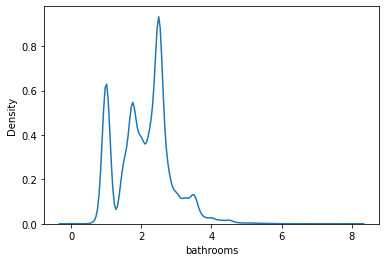

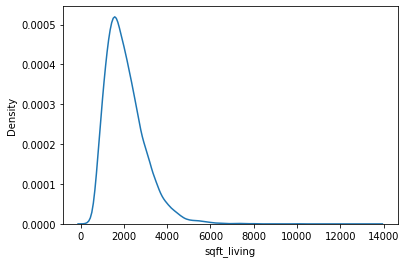

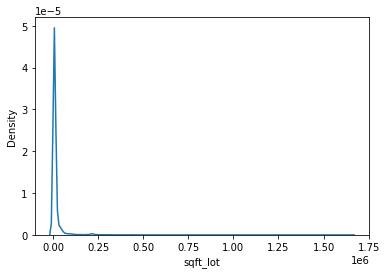

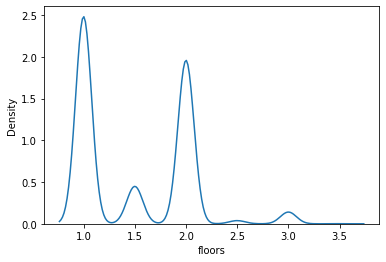

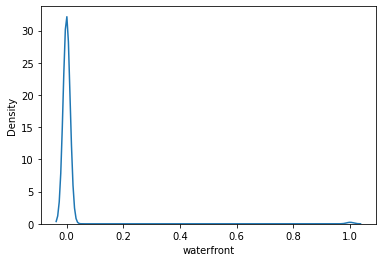

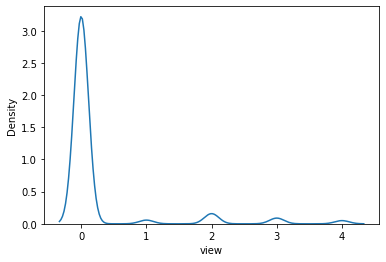

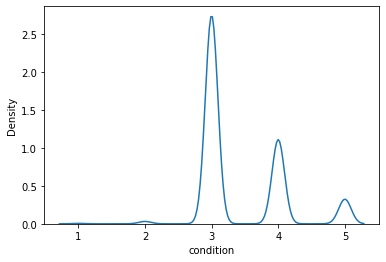

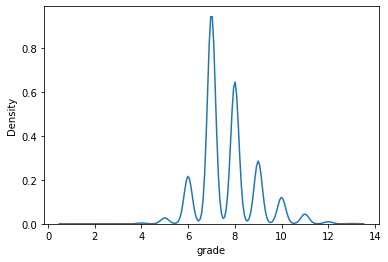

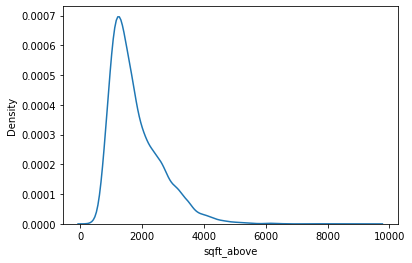

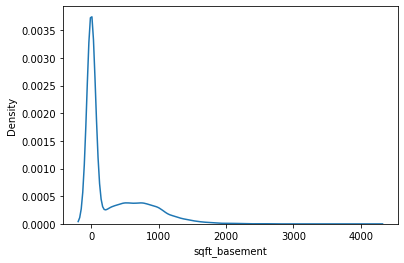

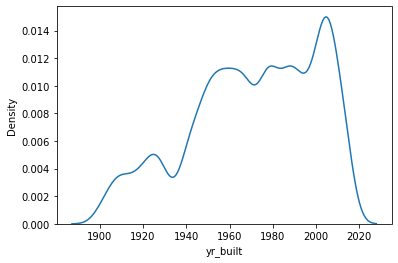

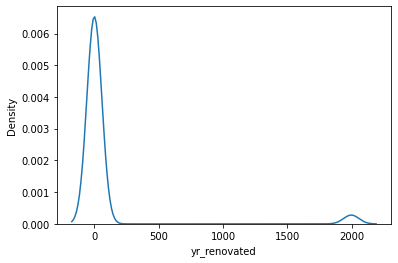

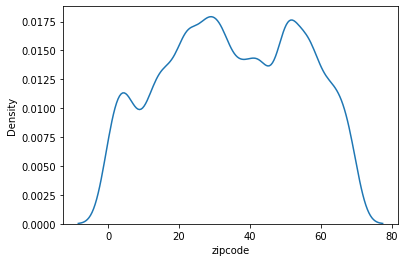

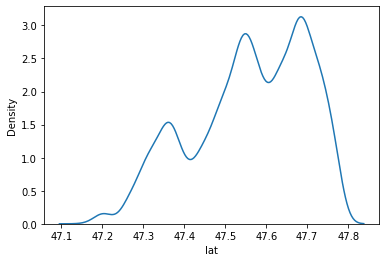

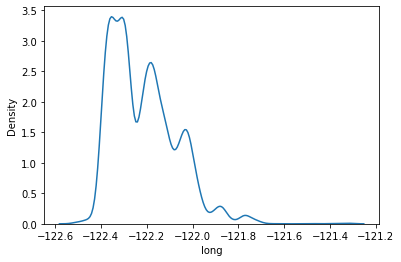

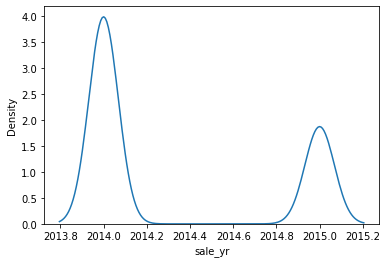

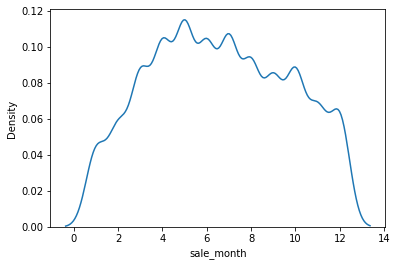

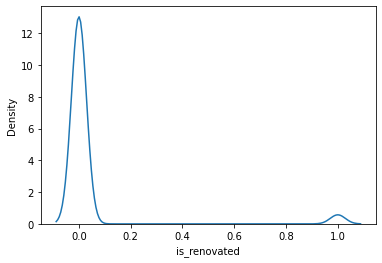

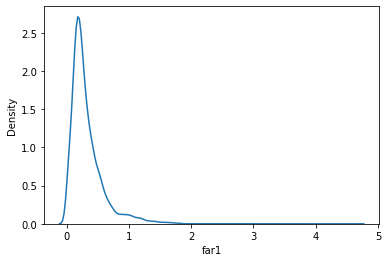

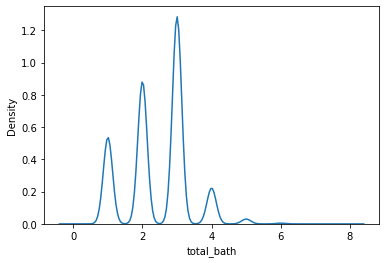

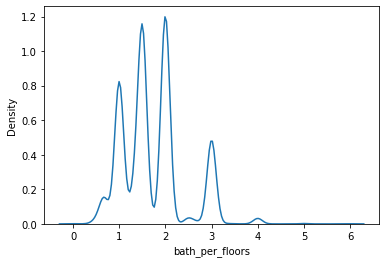

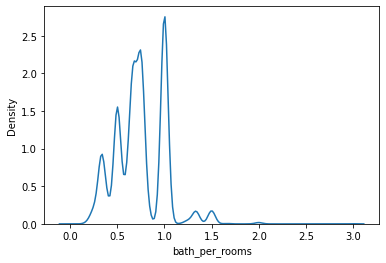

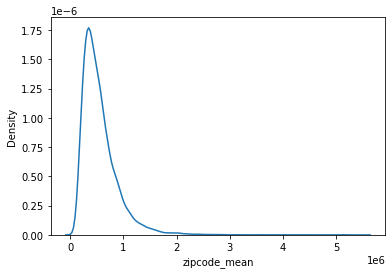

In [61]:
for c in df_train.columns:
	sns.kdeplot(df_train[c])
	plt.show()

In [62]:
skew_columns = [
    'sqft_living', 
    'sqft_lot', 
    'sqft_above',
    'sqft_basement',
    'far1',
    'zipcode_mean']

In [63]:
for df in [df_train, df_test]:
	for c in skew_columns:
		df[c] = np.log1p(df[c])

df_train['price'] = np.log1p(df_train['price'])

In [64]:
df_train_target = df_train['price']
df_train_features = df_train.drop(['price'], axis=1)

In [65]:
#아래 코드는 파이썬 머신러닝 완벽가이드에서 가져옴.

In [66]:
def print_best_params(model, params):
    grid_model = GridSearchCV(
        model, 
        param_grid = params,
        cv=5,
        scoring='neg_mean_squared_error')

    grid_model.fit(df_train_features, df_train_target)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print(
        '{0} 5 CV 시 최적 평균 RMSE 값 {1}, 최적 alpha:{2}'.format(model.__class__.__name__, np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

In [67]:
xgb_params ={                                     
    'learning_rate': [0.05],
    'max_depth': [5],
    'subsample': [0.9],
    'colsample_bytree': [0.5],
    'silent': [True],
    'gpu_id':[0] ,         
    'tree_method':['gpu_hist'],
    'predictor':['gpu_predictor'],
    'n_estimators':[1000],
    'refit' : [True]
}

xgb_model = XGBRegressor()
xgb_estimator = print_best_params(xgb_model, xgb_params)

XGBoostError: [13:50:16] ../src/data/data.cc:945: Check failed: valid: Input data contains `inf` or `nan`
Stack trace:
  [bt] (0) /opt/conda/lib/python3.9/site-packages/xgboost/lib/libxgboost.so(+0x9133f) [0x7f7a3489c33f]
  [bt] (1) /opt/conda/lib/python3.9/site-packages/xgboost/lib/libxgboost.so(+0x14e930) [0x7f7a34959930]
  [bt] (2) /opt/conda/lib/python3.9/site-packages/xgboost/lib/libxgboost.so(+0x15f8ff) [0x7f7a3496a8ff]
  [bt] (3) /opt/conda/lib/python3.9/site-packages/xgboost/lib/libxgboost.so(+0x156cf5) [0x7f7a34961cf5]
  [bt] (4) /opt/conda/lib/python3.9/site-packages/xgboost/lib/libxgboost.so(XGDMatrixCreateFromMat_omp+0x7c) [0x7f7a3489404c]
  [bt] (5) /opt/conda/lib/python3.9/lib-dynload/../../libffi.so.8(+0x6a4a) [0x7f7ac207aa4a]
  [bt] (6) /opt/conda/lib/python3.9/lib-dynload/../../libffi.so.8(+0x5fea) [0x7f7ac2079fea]
  [bt] (7) /opt/conda/lib/python3.9/lib-dynload/_ctypes.cpython-39-x86_64-linux-gnu.so(+0x13dc7) [0x7f7ac2093dc7]
  [bt] (8) /opt/conda/lib/python3.9/lib-dynload/_ctypes.cpython-39-x86_64-linux-gnu.so(+0x14454) [0x7f7ac2094454]



In [ ]:
lgb_params = {
    'objective':['regression'],
    'num_leave' : [1],
    'learning_rate' : [0.05],
    'n_estimators':[1000],
    'max_bin' : [80],
    'gpu_id':[0] ,         
    'tree_method':['gpu_hist'],
    'predictor':['gpu_predictor'],
    'refit':[True]
}

lgb_model = LGBMRegressor()
lgb_estimator = print_best_params(lgb_model, lgb_params)

In [ ]:
xgb_preds = xgb_estimator.predict(df_test)
lgb_preds = lgb_estimator.predict(df_test)
preds = 0.5* xgb_preds + 0.5*lgb_preds

In [68]:
submission=pd.read_csv('../input/sample_submission.csv')
submission['price']=np.exp(preds)
submission.to_csv('xgb_lgb_submission.csv',index=False)

FileNotFoundError: [Errno 2] No such file or directory: '../input/sample_submission.csv'

In [ ]:
#우선 그대로 건축에 대해 조금 전문적으로 들어간것 같아서 한번 해보려고 했는데 너무 오랜만에 건축에 관련된것을 해서 그런지 제대로 하지 못했다.
#그대로 배껴 오는것에서 계속 오류가 나 하지 못했다.
#우선 여러 요소를 블랜딩하여 해보려고 했으나 어떻게 적용해야 될지 조금 난감하였다.
#아직 캐글정도의 과정보단 조금 쉬운것 위주로 어떤 것이든 코딩을 좀 해봐야 겠다는 걸 느낄 수 있었다.
#한번 밀리니까 따라잡기가 너무 힘드네요.
#앞에 노드를 이해하는데 시간을 너무 쓴 것 같다. 그래도 앞의 과정은 대부분 이해는 할 수 있었는데 실제 적용을 하려면 쫌 멍해지는것 같다
#코딩을 숙제처럼 하니까 더 안하는것 같아서 나만의 프로젝트 아무거나 하나를 진행하려고 한다.
# 결과적으론 이번엔 대 실패. 시간을 맞춰 내는것에 급급했다.